In [3]:
import sys, glob, site
print("PY:", sys.executable)  # 應是 /opt/anaconda3/envs/invest/bin/python
print("CWD masks:", glob.glob("./db_dtypes*"))
print("site-packages:", site.getsitepackages() if hasattr(site,"getsitepackages") else site.getusersitepackages())


PY: /opt/anaconda3/envs/invest/bin/python
CWD masks: []
site-packages: ['/opt/anaconda3/envs/invest/lib/python3.11/site-packages']


In [6]:
import site, glob, os, shutil, sys

paths = site.getsitepackages() if hasattr(site, "getsitepackages") else [site.getusersitepackages()]
targets = []
for base in paths:
    targets += glob.glob(os.path.join(base, "db_dtypes*"))

print("Found:", targets)
for p in targets:
    try:
        if os.path.isdir(p):
            shutil.rmtree(p)
        else:
            os.remove(p)
    except Exception as e:
        print("Failed to remove:", p, e)
print("Cleanup done.")


Found: ['/opt/anaconda3/envs/invest/lib/python3.11/site-packages/db_dtypes-1.4.3.dist-info']
Cleanup done.


In [7]:
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip",
                       "install", "--force-reinstall", "--no-deps", "--no-cache-dir",
                       "db-dtypes==1.4.3"])


0

In [8]:
import db_dtypes, importlib
importlib.invalidate_caches()
print("db-dtypes:", getattr(db_dtypes, "__version__", "?"), "->", db_dtypes.__file__)


db-dtypes: ? -> /opt/anaconda3/envs/invest/lib/python3.11/site-packages/db_dtypes/__init__.py


In [9]:
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "--no-cache-dir",
    "pandas>=2.0,<3.0", "pyarrow>=14,<19",
    "google-cloud-bigquery>=3.25.0", "google-cloud-bigquery-storage>=2.24.0"])


0

In [3]:
import os
from google.cloud import bigquery

# 設定憑證路徑
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/jk/Python/key/bigquery.json"

client = bigquery.Client(project="crucial-alpha-174913")




In [17]:
sql = "SELECT Max(trip_start_timestamp) FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` limit 6000"
df_all = client.query(sql).to_dataframe()

E0000 00:00:1759038422.178340  682149 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [14]:
max_sql = "SELECT MAX(fare) as max_fare, MIN(fare) as min_fare, AVG(fare) as avg_fare, MIN(trip_seconds) FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` WHERE trip_seconds >= 600 "

result = client.query(max_sql).to_dataframe()

E0000 00:00:1759016117.920590  292376 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [16]:
max_sql = "SELECT AVG(fare) as avg_fare FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` WHERE dropoff_location is not null GROUP BY dropoff_location ORDER BY avg_fare DESC LIMIT 5"

result_df = client.query(max_sql).to_dataframe()

E0000 00:00:1759016330.067798  292376 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [4]:
trip_2year = "SELECT * FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` WHERE trip_start_timestamp >= '2022-01-01'" 

df = client.query(trip_2year).to_dataframe()

E0000 00:00:1759111137.491483 1216176 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [5]:
#hadling any missing values in the trip_seconds column (0 should not be existed)
df = df[df['trip_seconds']>0]



In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly
import matplotlib.dates as mdates


In [21]:
df['Month'] = df['trip_start_timestamp'].dt.month
df['Year'] = df['trip_start_timestamp'].dt.year

In [33]:
df['year_month'] = df['trip_start_timestamp'].dt.to_period('M')
trend_data = df.set_index('trip_start_timestamp').groupby(pd.Grouper(freq='M')).agg(trips = ('fare','count'),avg_fare = ('fare','mean'), avg_miles = ('trip_miles','mean')).reset_index(names = 'year_month')


/var/folders/26/r7gb_vfx1fzdcf0xczs61z2w0000gn/T/ipykernel_24256/1152529877.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['trip_start_timestamp'].dt.to_period('M')
/var/folders/26/r7gb_vfx1fzdcf0xczs61z2w0000gn/T/ipykernel_24256/1152529877.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  trend_data = df.set_index('trip_start_timestamp').groupby(pd.Grouper(freq='M')).agg(trips = ('fare','count'),avg_fare = ('fare','mean'), avg_miles = ('trip_miles','mean')).reset_index(names = 'year_month')


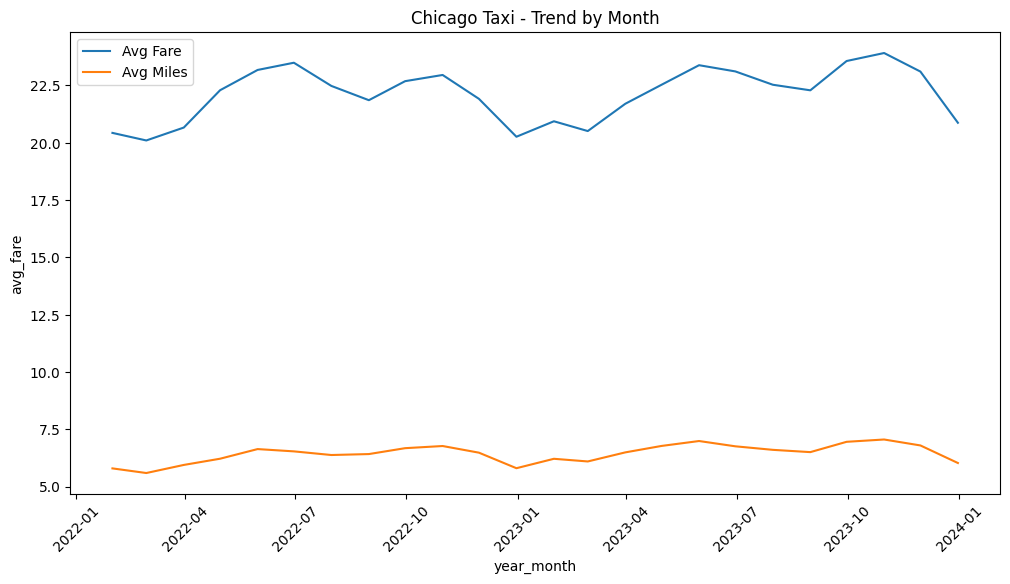

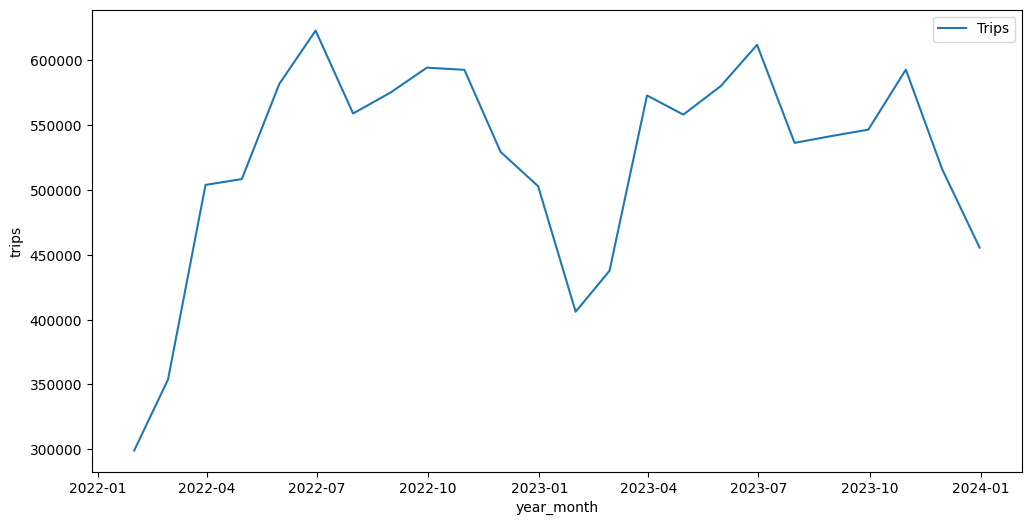

In [36]:
plt.figure(figsize=(12,6))
# sns.lineplot(data = trend_data, x= 'year_month', y = 'trips', label = 'Trips')
sns.lineplot(data=trend_data, x='year_month', y='avg_fare', label='Avg Fare')
sns.lineplot(data=trend_data, x='year_month', y='avg_miles', label='Avg Miles')
plt.xticks(rotation=45)
plt.title("Chicago Taxi - Trend by Month")
plt.show()
plt.figure(figsize=(12,6))
sns.lineplot(data = trend_data, x= 'year_month', y = 'trips', label = 'Trips')
plt.show()

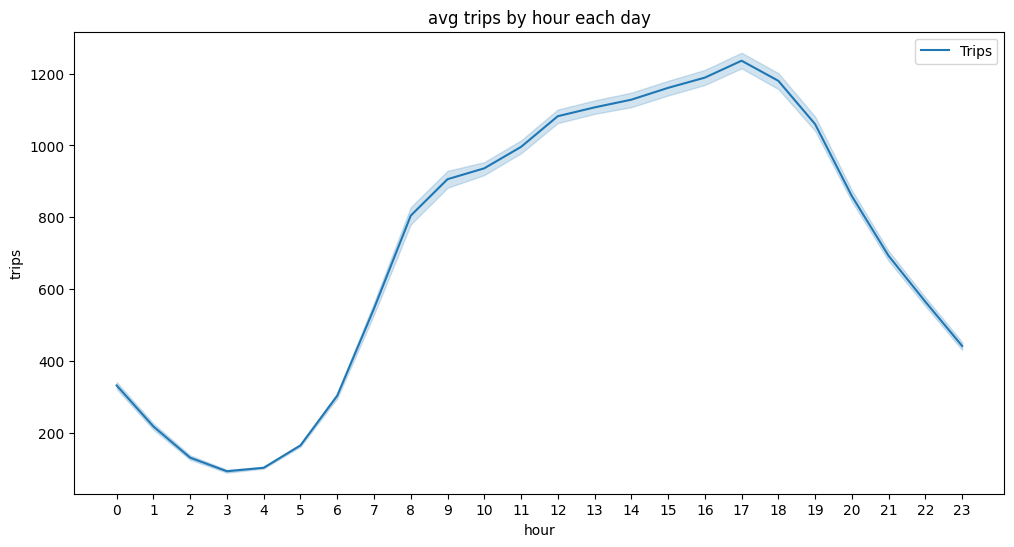

In [45]:
hour_data = df.set_index('trip_start_timestamp').groupby(pd.Grouper(freq = 'h')).agg(trips = ('fare', 'count'), avg_fare = ('fare','mean'), avg_miles = ('trip_miles','mean')).reset_index(names = 'hour')
hour_data['hour'] = hour_data['hour'].dt.hour

plt.figure(figsize=(12,6))
sns.lineplot(data = hour_data, x = 'hour', y = 'trips', label = 'Trips')
plt.title('avg trips by hour each day')
plt.xticks(range(0,24))
plt.show()

In [44]:
company_data = df.groupby('company').agg(trips = ('fare', 'count'), avg_fare = ('fare','mean'), avg_miles = ('trip_miles','mean')).reset_index()

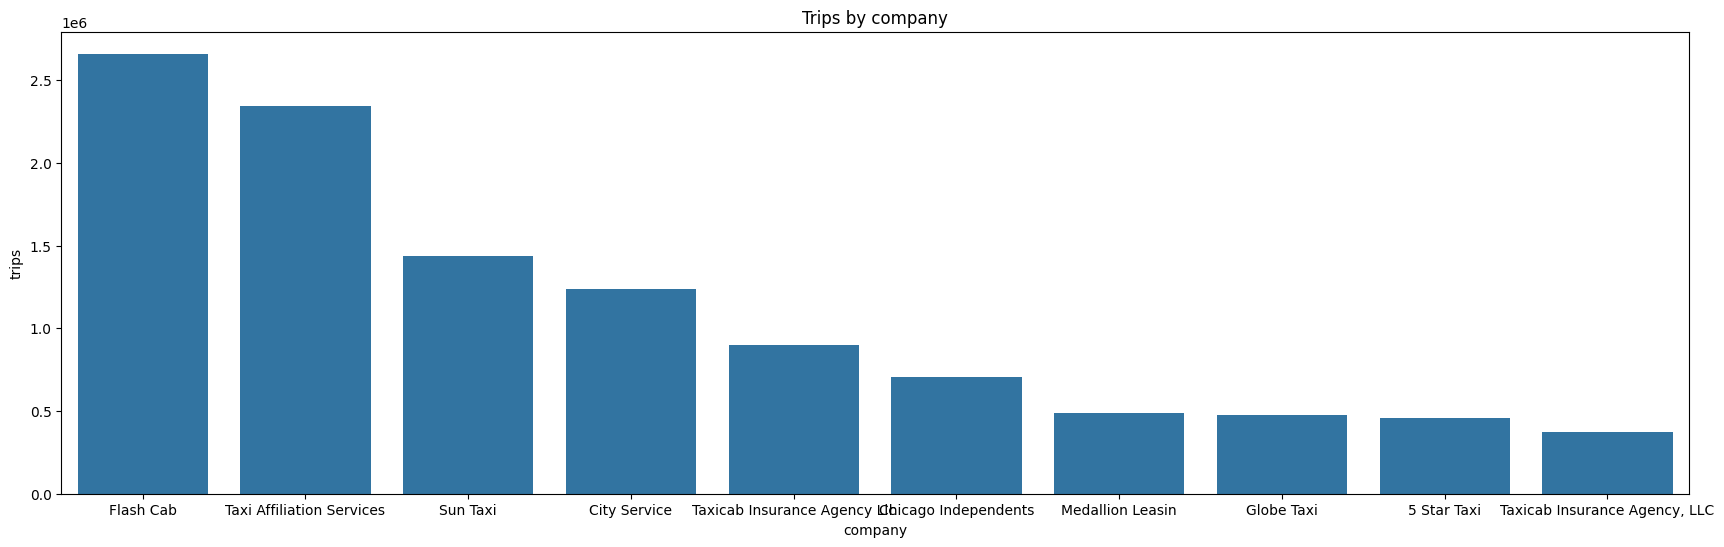

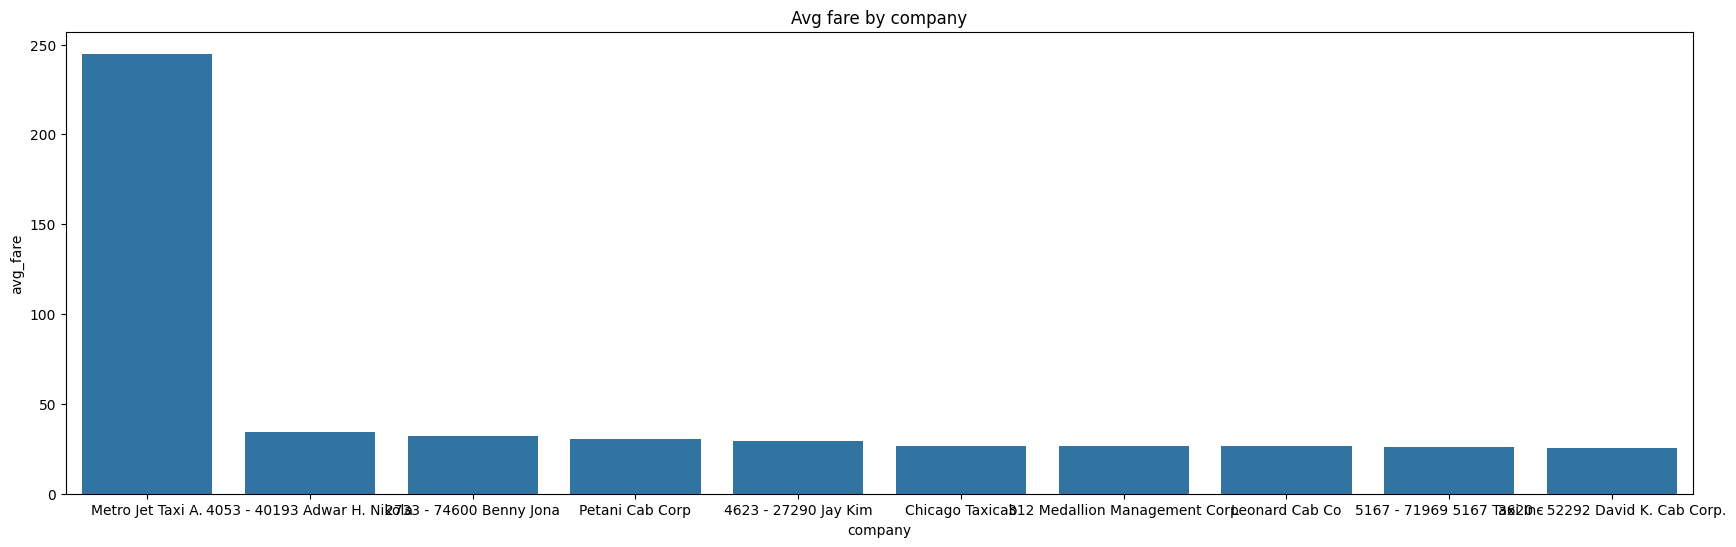

In [52]:
#which comany has the highest trips
plt.figure(figsize=(21,6))
sns.barplot(data = company_data.sort_values(by = 'trips', ascending = False).head(10),x = 'company',y = 'trips')
plt.title('Trips by company')
plt.show()
plt.figure(figsize = (21,6))
sns.barplot(data = company_data.sort_values(by = 'avg_fare', ascending = False).head(10), x = 'company', y = 'avg_fare')
plt.title('Avg fare by company')
plt.show() 

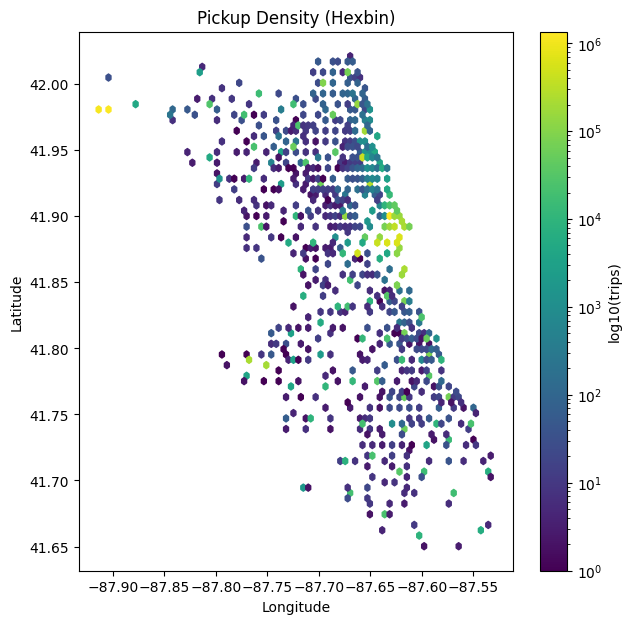

In [7]:
df_hex = df[['pickup_latitude','pickup_longitude']].dropna()
df_hex = df_hex.query('41.6 <= pickup_latitude <= 42.1 and -88 <= pickup_longitude <= -87.3')

plt.figure(figsize=(7,7))
hb = plt.hexbin(df_hex['pickup_longitude'], df_hex['pickup_latitude'],
                gridsize=80, bins='log')  # gridsize 調密度
plt.xlabel('Longitude'); plt.ylabel('Latitude')
cb = plt.colorbar(hb); cb.set_label('log10(trips)')
plt.title('Pickup Density (Hexbin)')
plt.show()


In [ ]:
m = folium.Map(location=[41.8781, -87.6298], zoom_start=11)
HeatMap(df[['pickup_latitude','pickup_longitude']].dropna().values.tolist()).add_to(m)

m  # 在 Jupyter Notebook 裡直接輸出就會顯示

In [8]:
import folium
from folium.plugins import HeatMap

# 基本清理：去掉異常 / 缺值
df_map = df[['pickup_latitude','pickup_longitude']].dropna()
# 限定芝加哥大概範圍（避免髒資料拉走視野）
df_map = df_map.query('41.6 <= pickup_latitude <= 42.1 and -88 <= pickup_longitude <= -87.3')

# 取樣（避免一次點太多卡頓）
\
df_s = df_map.sample(n=min(len(df_map), 80_000), random_state=42)

m = folium.Map(location=[41.8781, -87.6298], zoom_start=11, tiles='CartoDB positron')
HeatMap(df_s[['pickup_latitude','pickup_longitude']].values.tolist(),
        radius=8, blur=12, max_zoom=13).add_to(m)
m  # 在 Jupyter 會顯示地圖


In [9]:
m.save('chicago_taxi_heatmap.html')  # 儲存成 HTML 檔案